## Train for Baseline Model (End - to - End)
### Load H5 file & Explore

In [1]:
# import required packages

import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import h5py
import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from scipy.spatial.transform import Rotation as R
import pickle
from sklearn.preprocessing import StandardScaler

### Load the processed data

In [10]:
# training_file_path = "Train1_20250321_143506_go2.pkl"   # Training file path - controller Mu = 0.7
# training_file_path = "Train2_20250326_154150_go2.pkl"   # Training file path - controller Mu = 0.3
training_file_path = "ROLL_CMD_Train2_20250326_154150_go2.pkl"   # Training file path - controller Mu = 0.3, Roll and V_cmd data added

with open(training_file_path, "rb") as file:
    Processed_dataset = pickle.load(file)

# print(len(Processed_dataset))
print(Processed_dataset[0].shape)

(34424, 32)


### Construct DNN model
#### (  Set related params!  )

In [31]:
# Set model characteristics
structure = "FCNN"   # choose among - "FCNN", "LSTM", "Transformer"
horizon = 200  # the number of timesteps to include in feed-forward ( = size of DNN's input! )


# Set train params
activation = "Tanh"   # choose among - "Sigmoid", "ReLU", "ELU"
epoch = 300   # Number of epochs
lr = 0.0001   # Learning rate
batch = 128   # Batch size


def ActFunc(act):
    if act == "ReLU":
        return nn.ReLU
    elif act == "LeakyReLU":
        return nn.LeakyReLU
    elif act == "ELU":
        return nn.ELU
    elif act == "Sigmoid":
        return nn.Sigmoid
    elif act == "Tanh":
        return nn.Tanh
    else:
        return "Wrong input"


# Random sampling & Generate DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, scene_list, horizon_size=200):
        """
        data: time-serial data (Numpy array)
        horizon_size: the number of continuous time steps
        """
        self.scene_list = scene_list
        self.horizon_size = horizon_size
        self.samples = []

        # Build index mapping for all samples across scenes
        for scene_idx, scene in enumerate(scene_list):
            max_start = len(scene) - horizon_size
            for i in range(max_start):
                self.samples.append((scene_idx, i))
        
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        scene_idx, start_idx = self.samples[idx]
        scene = self.scene_list[scene_idx]

        x_trj = scene[start_idx:start_idx + self.horizon_size, 4:31]   # Trajectory Input
        x_trj = x_trj.reshape(-1)  # Flatten
        x_cur = scene[start_idx + self.horizon_size, 0:4]   # Current State Input

        x = torch.cat((torch.tensor(x_trj, dtype=torch.float32), torch.tensor(x_cur, dtype=torch.float32)), dim=0)
        y = scene[start_idx + self.horizon_size, 31]   # Output
        
        # x = torch.tensor(x, dtype=torch.float32)
        x = x.clone().detach().float()
        y = torch.tensor([y], dtype=torch.float32)
        return x, y

dataset = TimeSeriesDataset(Processed_dataset, horizon_size=horizon)
print(dataset)

dataloader = DataLoader(dataset, batch_size=batch, shuffle=True, num_workers=4)

# DataLoader exploration
for batch_idx, (inputs, labels) in enumerate(dataloader):
    print(f'Batch {batch_idx + 1}: Input Size {inputs.shape}, Label Size {labels.shape}')

Batch 1: Input Size torch.Size([128, 5404]), Label Size torch.Size([128, 1])
Batch 2: Input Size torch.Size([128, 5404]), Label Size torch.Size([128, 1])
Batch 3: Input Size torch.Size([128, 5404]), Label Size torch.Size([128, 1])
Batch 4: Input Size torch.Size([128, 5404]), Label Size torch.Size([128, 1])
Batch 5: Input Size torch.Size([128, 5404]), Label Size torch.Size([128, 1])
Batch 6: Input Size torch.Size([128, 5404]), Label Size torch.Size([128, 1])
Batch 7: Input Size torch.Size([128, 5404]), Label Size torch.Size([128, 1])
Batch 8: Input Size torch.Size([128, 5404]), Label Size torch.Size([128, 1])
Batch 9: Input Size torch.Size([128, 5404]), Label Size torch.Size([128, 1])
Batch 10: Input Size torch.Size([128, 5404]), Label Size torch.Size([128, 1])
Batch 11: Input Size torch.Size([128, 5404]), Label Size torch.Size([128, 1])
Batch 12: Input Size torch.Size([128, 5404]), Label Size torch.Size([128, 1])
Batch 13: Input Size torch.Size([128, 5404]), Label Size torch.Size([128,

In [32]:
# ======================== Device Check ========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Current device:", device)
if torch.cuda.is_available():
    print("CUDA device name:", torch.cuda.get_device_name(0))
    print("CUDA device count:", torch.cuda.device_count())
# =============================================================


##### Define DNN model class


# Define FCNN model class
class FCNN(nn.Module):
    def __init__(self, input_dim, hidden_layers, output_dim=1, activation_fn=nn.ReLU):
        super(FCNN, self).__init__()

        self.flatten = nn.Flatten(start_dim=1)

        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(activation_fn())
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, output_dim))  # Output Layer

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        # x = x.view(x.shape[0], -1)
        return self.network(x)

# Model Train
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    L = []
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        L.append( running_loss/len(train_loader) )
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.8f}")

    return L


# Model Evaluation
# def evaluate_model(model, test_loader):
#     model.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for inputs, targets in test_loader:
#             inputs = inputs.to(device)
#             targets = targets.to(device)

#             outputs = model(inputs)
#             _, predicted = torch.max(outputs, 1)
#             total += targets.size(0)
#             correct += (predicted == targets).sum().item()

#     accuracy = 100 * correct / total
#     print(f"Accuracy: {accuracy:.2f}%")




########################################## Hyper-parameter Set ##########################################


hidden_layers = [2048, 1024, 512, 256, 64]  # hidden layer property


########################################## Hyper-parameter Set ##########################################


activation_fn = ActFunc(activation)
input_dim = horizon * 27 + 4
output_dim = 1

model = FCNN(input_dim, hidden_layers, output_dim, activation_fn).to(device)   # Initialize Model

criterion = nn.MSELoss()  # Loss function
optimizer = optim.Adam(model.parameters(), lr, weight_decay=0.001) # Optimizer


# test_dataset = 

train_loader = dataloader
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Train & Evaluation
Loss = train_model(model, train_loader, criterion, optimizer, num_epochs=epoch)
# evaluate_model(model, test_loader)

Current device: cuda
CUDA device name: NVIDIA GeForce RTX 4090
CUDA device count: 1
Epoch [1/300], Loss: 0.03389325
Epoch [2/300], Loss: 0.00493876
Epoch [3/300], Loss: 0.00364200
Epoch [4/300], Loss: 0.00328700
Epoch [5/300], Loss: 0.00291299
Epoch [6/300], Loss: 0.00284343
Epoch [7/300], Loss: 0.00305487
Epoch [8/300], Loss: 0.00202838
Epoch [9/300], Loss: 0.00240482
Epoch [10/300], Loss: 0.00816604
Epoch [11/300], Loss: 0.00202924
Epoch [12/300], Loss: 0.00219856
Epoch [13/300], Loss: 0.00223092
Epoch [14/300], Loss: 0.00238324
Epoch [15/300], Loss: 0.00384302
Epoch [16/300], Loss: 0.00158047
Epoch [17/300], Loss: 0.00205223
Epoch [18/300], Loss: 0.00208816
Epoch [19/300], Loss: 0.00567167
Epoch [20/300], Loss: 0.00156946
Epoch [21/300], Loss: 0.00193982
Epoch [22/300], Loss: 0.00203449
Epoch [23/300], Loss: 0.00198857
Epoch [24/300], Loss: 0.00205748
Epoch [25/300], Loss: 0.00195189
Epoch [26/300], Loss: 0.01118875
Epoch [27/300], Loss: 0.00214928
Epoch [28/300], Loss: 0.00229204
E

FCNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (network): Sequential(
    (0): Linear(in_features=5404, out_features=2048, bias=True)
    (1): Tanh()
    (2): Linear(in_features=2048, out_features=1024, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): Tanh()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): Tanh()
    (8): Linear(in_features=256, out_features=64, bias=True)
    (9): Tanh()
    (10): Linear(in_features=64, out_features=1, bias=True)
  )
)


Text(0, 0.5, 'MSE')

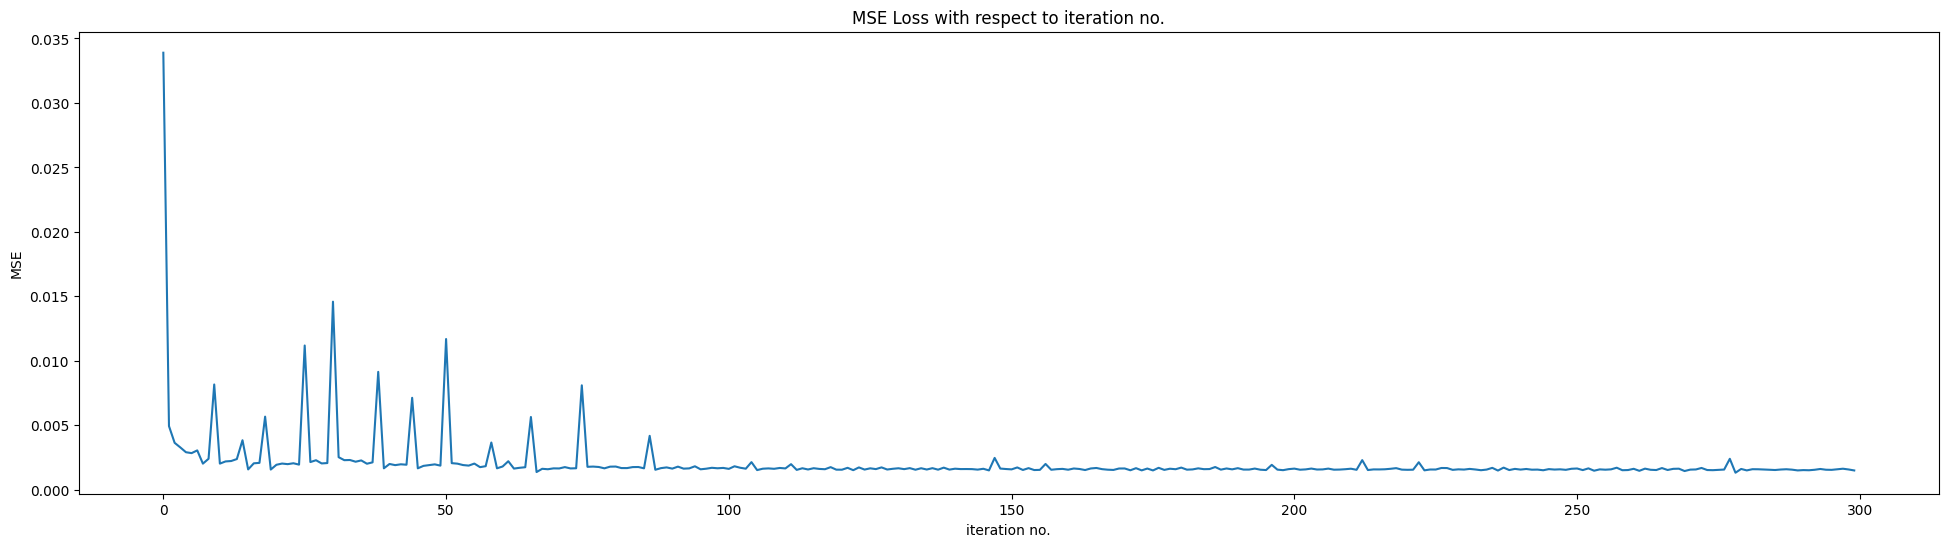

In [33]:
print( model )
plt.figure( figsize=(24, 6) )
plt.plot(Loss)
plt.title("MSE Loss with respect to iteration no.")
plt.xlabel("iteration no.")
plt.ylabel("MSE")

In [ ]:
# Save trained model

"""
2025-03-24 19:22
"""
# torch.save(model.state_dict(), "trained_model_1.pt")   # horizon 200, epoch 30, act Tanh, hidden_layers = [2048, 1024, 512, 256, 64]
# print("Model saved as trained_model_1.pt")

# torch.save(model.state_dict(), "trained_model_2.pt")   # horizon 1000, epoch 5, act Tanh, hidden_layers = [2048, 1024, 512, 256, 64]
# print("Model saved as trained_model_2.pt")s

# torch.save(model.state_dict(), "trained_model_3.pt")   # horizon 200, epoch 10, act ReLU, hidden_layers = [2048, 1024, 512, 256, 64]
# print("Model saved as trained_model_3.pt")

# torch.save(model.state_dict(), "trained_model_4.pt")   # horizon 200, epoch 10, act LeakyReLU, hidden_layers = [2048, 1024, 512, 256, 64]
# print("Model saved as trained_model_4.pt")

# torch.save(model.state_dict(), "trained_model_5.pt")   # horizon 200, epoch 10, act Tanh, hidden_layers = [2048, 1024, 512, 256, 64] ++ Norm!
# print("Model saved as trained_model_5.pt")

# torch.save(model.state_dict(), "trained_model_6.pt")   # horizon 200, epoch 10, act Tanh, hidden_layers = [2048, 1024, 512, 256, 64]  ++ Log1p scaling [NOTE]: Overfitting?? -- NO, too high learning rate
# print("Model saved as trained_model_6.pt")

Model saved as trained_model_6.pt


In [22]:
# model.load_state_dict(torch.load("trained_model_1.pt"))

model.eval()
print(model)
with open('Valid1_20250322_155701_go2.pkl', 'rb') as f:   # Validation Episode
    valid_data = pickle.load(f)

print(valid_data[0].dtype)

buff = np.zeros((valid_data[0].shape[0], 1))
print(buff.shape)

for i in range( len(buff) - horizon ):
    test = torch.tensor( valid_data[0][i:i+horizon, 0:27].flatten(), dtype=torch.float32).unsqueeze(0)
    test = test.to(device)
    with torch.no_grad():
        predictions = model(test)
    buff[i] = predictions.cpu().detach().numpy()

print("Outputs")
print(buff)

FCNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (network): Sequential(
    (0): Linear(in_features=5404, out_features=2048, bias=True)
    (1): Tanh()
    (2): Linear(in_features=2048, out_features=1024, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): Tanh()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): Tanh()
    (8): Linear(in_features=256, out_features=64, bias=True)
    (9): Tanh()
    (10): Linear(in_features=64, out_features=1, bias=True)
  )
)
float64
(175039, 1)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x5400 and 5404x2048)

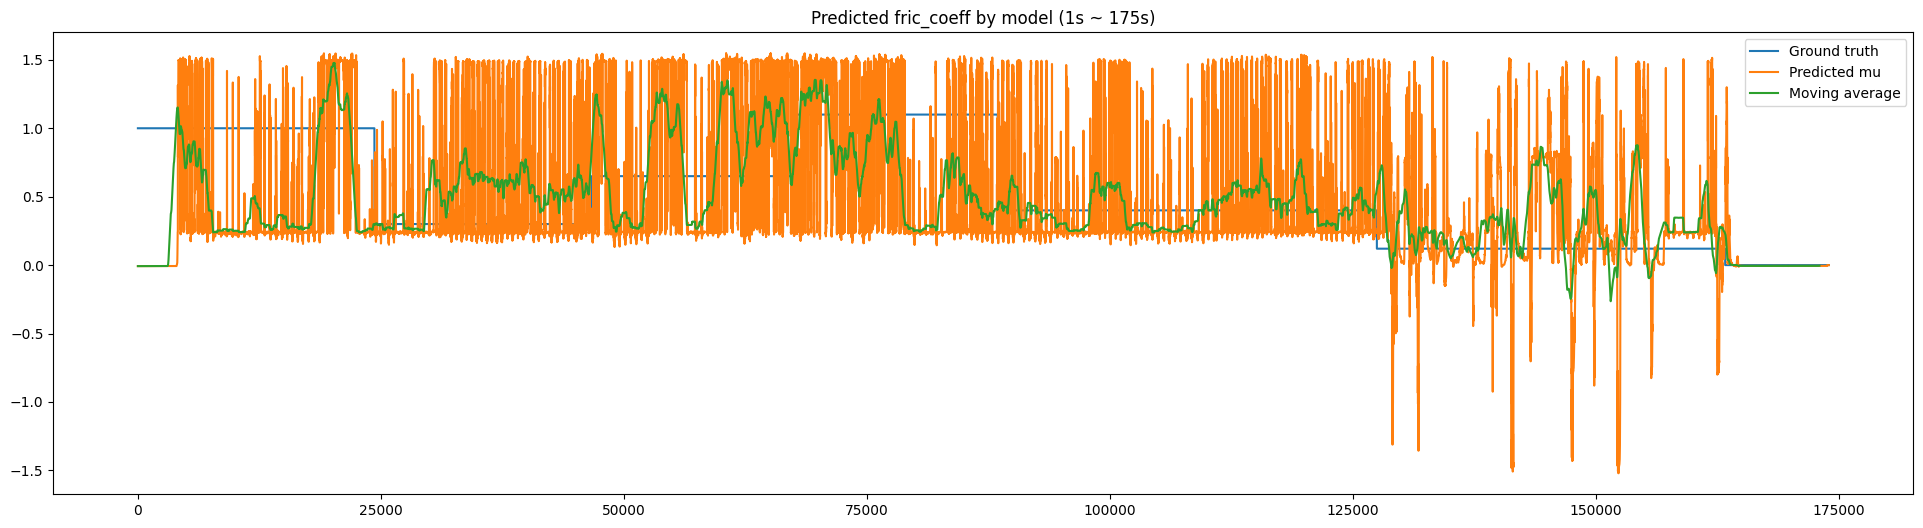

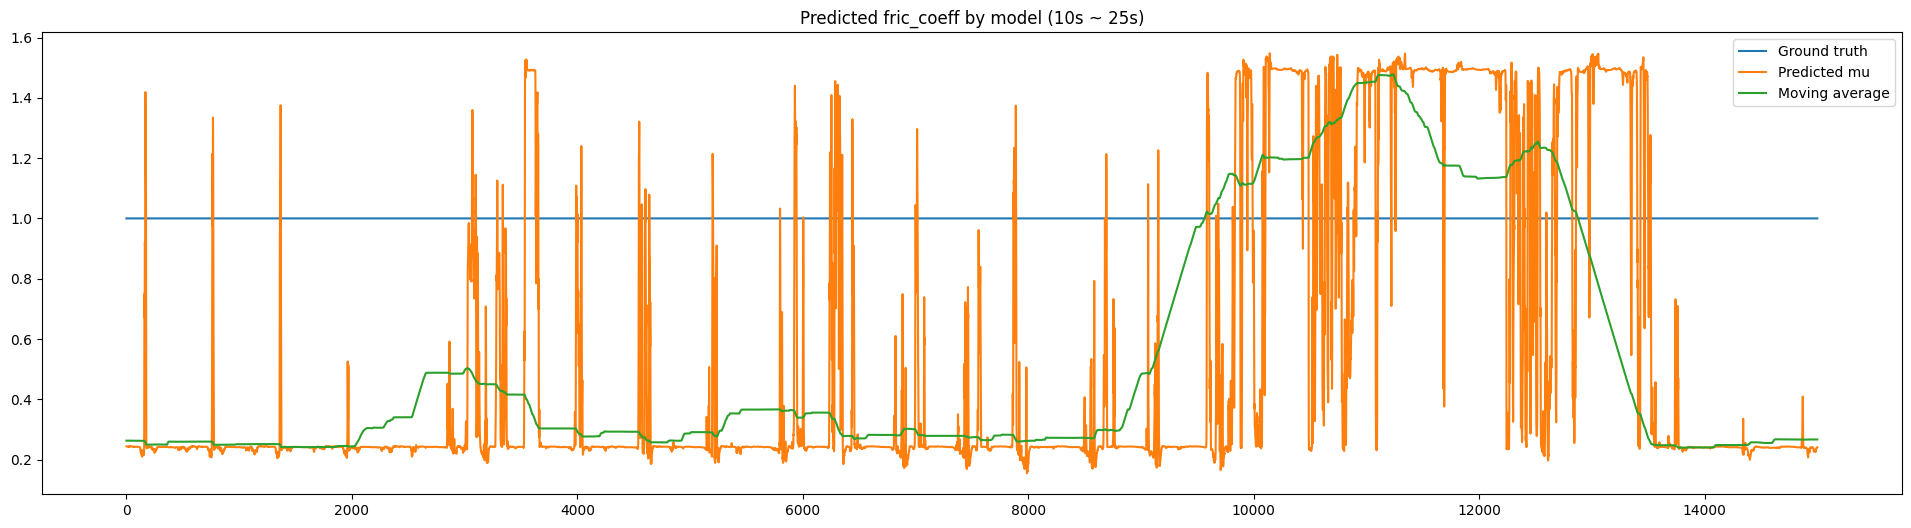

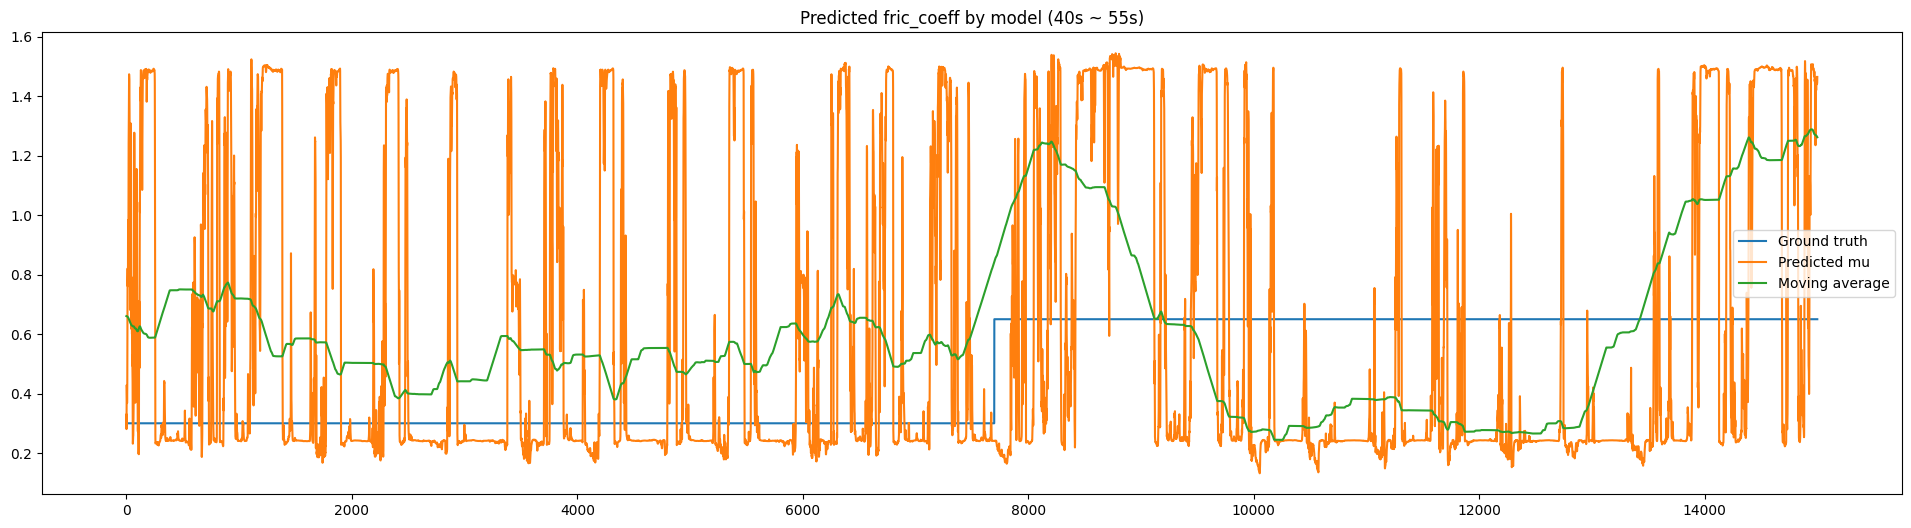

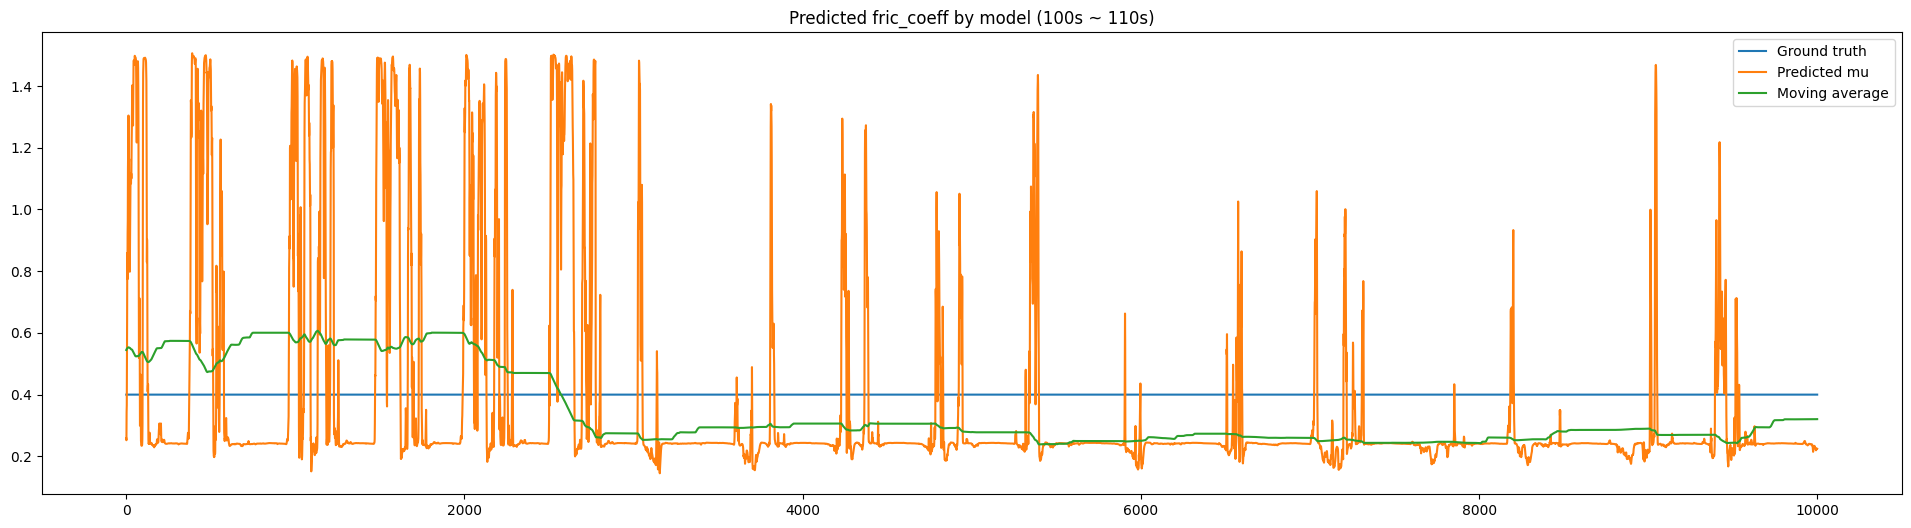

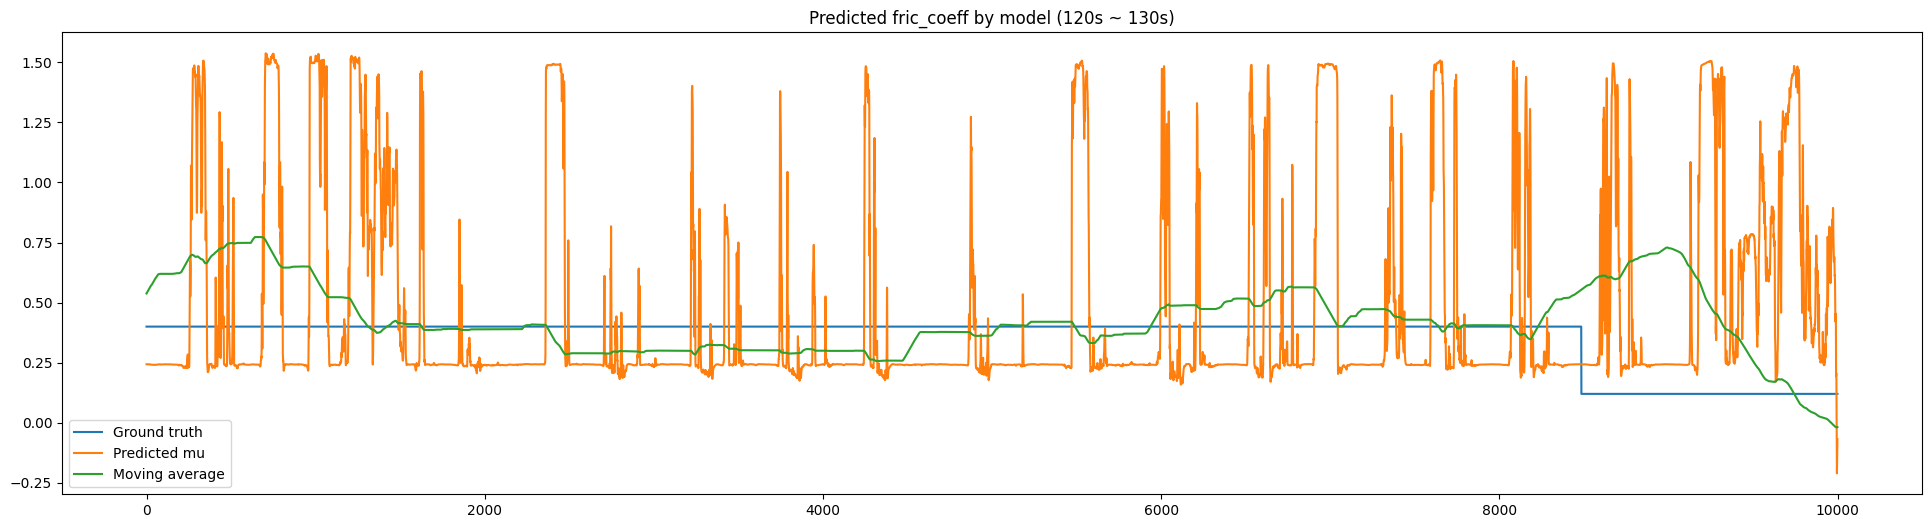

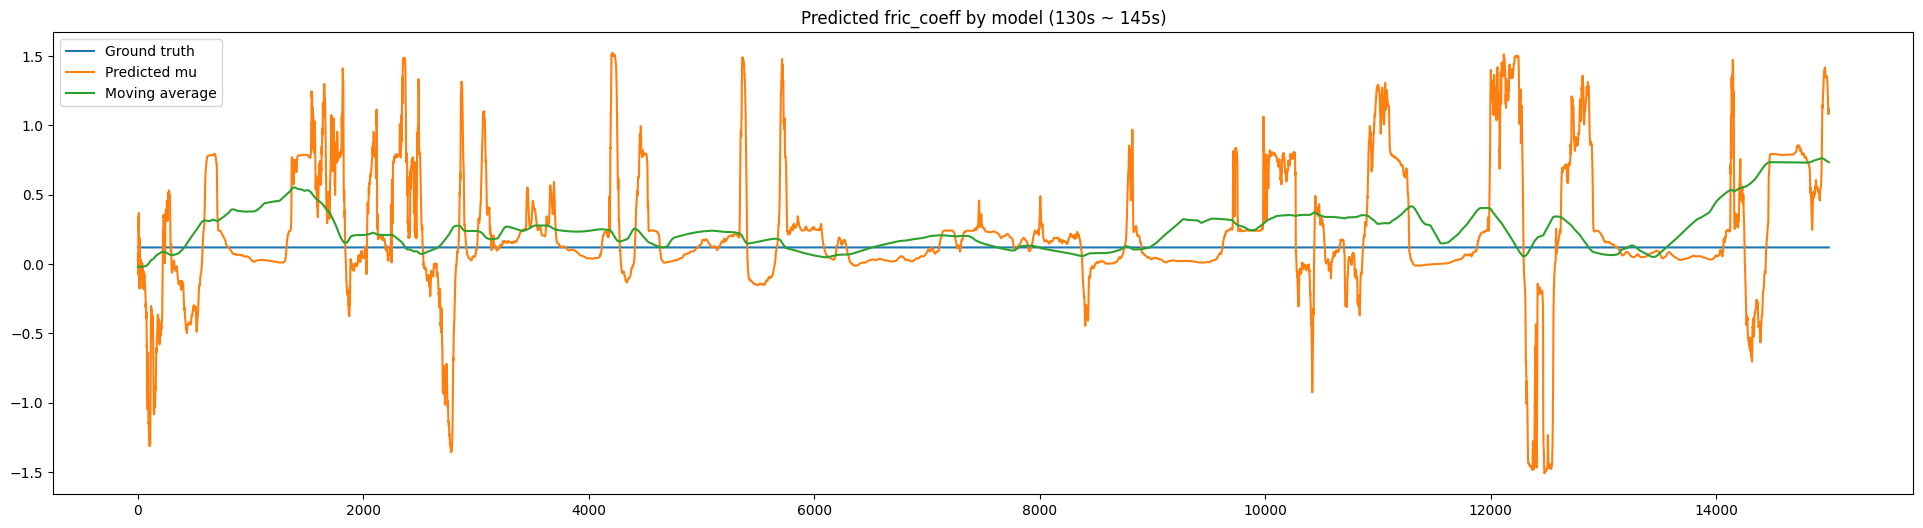

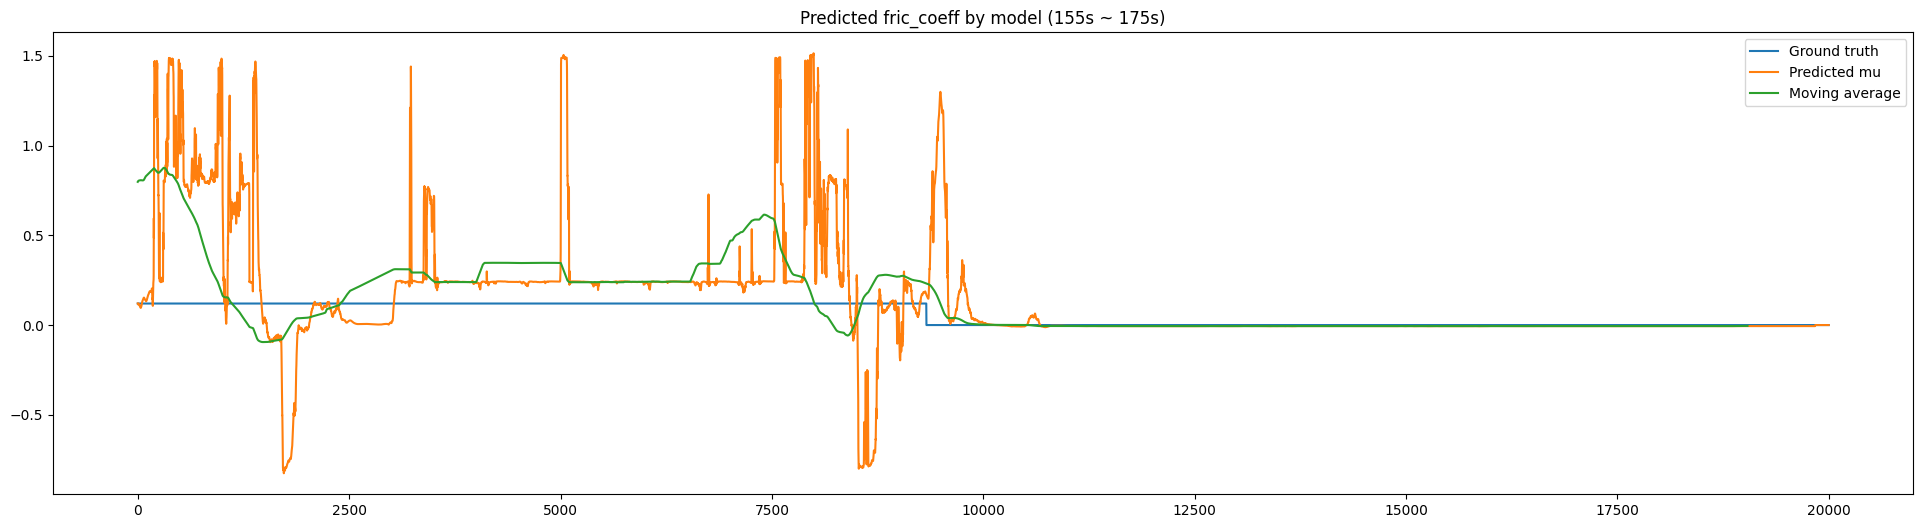

In [401]:
# print( model )

def moving_average(data, window_size):
    """Calculate the moving average of a 1D data array.
    
    Args:
        data (array-like): Input 1D data array.
        window_size (int): Size of the moving window.
    
    Returns:
        np.ndarray: Moving average result.
    """
    if window_size < 1:
        raise ValueError("Window size must be at least 1")
    
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

window_size = 1000
smoothed_data = moving_average(buff[:, 0], window_size)

def ShowPlot(t_i, t_f):
    plt.figure( figsize=(24,6) )
    plt.title(f"Predicted fric_coeff by model ({t_i}s ~ {t_f}s)")
    plt.plot(valid_data[0][t_i*1000:t_f*1000, 27])
    plt.plot(buff[t_i*1000:t_f*1000])
    plt.plot(smoothed_data[t_i*1000:t_f*1000])
    plt.legend(["Ground truth", "Predicted mu", "Moving average"])

ShowPlot(1, 175)
ShowPlot(10, 25)
ShowPlot(40, 55)
ShowPlot(100, 110)
ShowPlot(120, 130)
ShowPlot(130, 145)
ShowPlot(155, 175)